# Comparison of data collected from focal sampling vs drone video analysis

Download ` focalvsdrone`  files used in this analysis from [kabr-methodology collection](https://huggingface.co/datasets/imageomics/kabr-methodology/tree/main/focalvsdrone) in Hugging Face.

In [ ]:
"""
You need numpy, polars, scikit-learn and matplotlib to run this script:

pip install --upgrade numpy polars scikit-learn matplotlib

Then run python confusion_matrix_sam.py. 
It will save two files: confusion.pdf and confusion-with-out-of-sight.pdf.
"""

import os

import matplotlib.pyplot as plt
import numpy as np
import polars as pl
import sklearn.metrics
import re

data_root = "/focalvsdrone"

Notes on labels: Browse excluded since only zebra data used to compare drone vs field focal sampling. Run and Trot combined for readibility since behaviors are similar (locomotion). Labels arrange in descending order of occurance frequency in dataset. (See distribution plot.)

In [2]:
# labels = [
#     "Graze", "Walk", "Head Up", "Trot/Run", "Auto-Groom",
#      "Defecate", "Fight", "Out of Sight"
#     ]

labels = [
    "Graze", "Walk", "Head Up", "Run", 
    "Browse", "Trot", "Auto-Groom", "Out of Sight"]

In [41]:

# Regex patterns (case-insensitive) → canonical label
CATEGORY_PATTERNS = {
    r"(vigilant|stand|head\s*up|alert\s*vigilance|vigilance)":            "Head Up",
    r"(fight|chase)":                                           "Out of Sight",
    r"(out\s*of\s*sight|out\s*of\s*focus|"
    r"out\s*of\s*frame|occluded|no\s*data)":                    "Out of Sight",
    r"(trot|trotting)":                                         "Trot",
    r"(run|running)":                                            "Run",
    r"(walk|walking)":                                          "Walk",
    r"sniff":                                                    "Graze",
    r"graze":                                                    "Graze",
    r"browse|browsing":                                          "Browse",
    r"auto[-\s]*groom":                                         "Auto-Groom",
    r"Defecating|defecate|defecation":                     "Defecate",
    
}

def clean_categories(name: str) -> str:
    """
    Standardise free-text behaviour labels:
        * remove 'ing' variants (e.g. Running → Run)
        * merge Trot & Run
        * map all occlusion / missing-data phrases to 'Out of Sight'
    """
    text = name.lower()
    for pattern, canon in CATEGORY_PATTERNS.items():
        if re.search(pattern, text):
            return canon
    # If nothing matched, title-case the original so it fits the style
    return name.title()


def filter_label(y_true, y_pred, bad_label):
    return zip(
        *[
            (t, p)
            for t, p in zip(y_true, y_pred)
            if (t != bad_label) and (p != bad_label)
        ]
    )

def read_csvs(root):
    df = pl.concat([pl.read_csv(os.path.join(root, file)) for file in os.listdir(root)])
    df = df.rename({"focal_behavior": "field", "behavior": "drone"})
    return df


def make_cm(df, *, filter_oos=False):
    field = [clean_categories(label) for label in df.get_column("field").to_list()]
    drone = [clean_categories(label) for label in df.get_column("drone").to_list()]

    if filter_oos:
        field, drone = filter_label(field, drone, "Out of Sight")
      
    print("Field labels:", sorted(set(field)))
    print("Drone labels:", sorted(set(drone)))

    cm = sklearn.metrics.confusion_matrix(
        y_true=field, y_pred=drone, labels=labels, normalize="true"
    )

    return cm 


if __name__ == "__main__":
    #df = read_csvs(data_root)
    df = read_csvs('/fs/ess/PAS2136/Kenya-2023/Zebras/methods_paper_analysis/kabr-tools/_hugging_face/methodology_comparison/focalvsdrone/data')
    cm = make_cm(df, filter_oos=False)

Field labels: ['Graze', 'Head Up', 'Out of Sight', 'Trot', 'Walk']
Drone labels: ['Auto-Groom', 'Defecating', 'Graze', 'Head Up', 'Out of Sight', 'Trot', 'Walk']


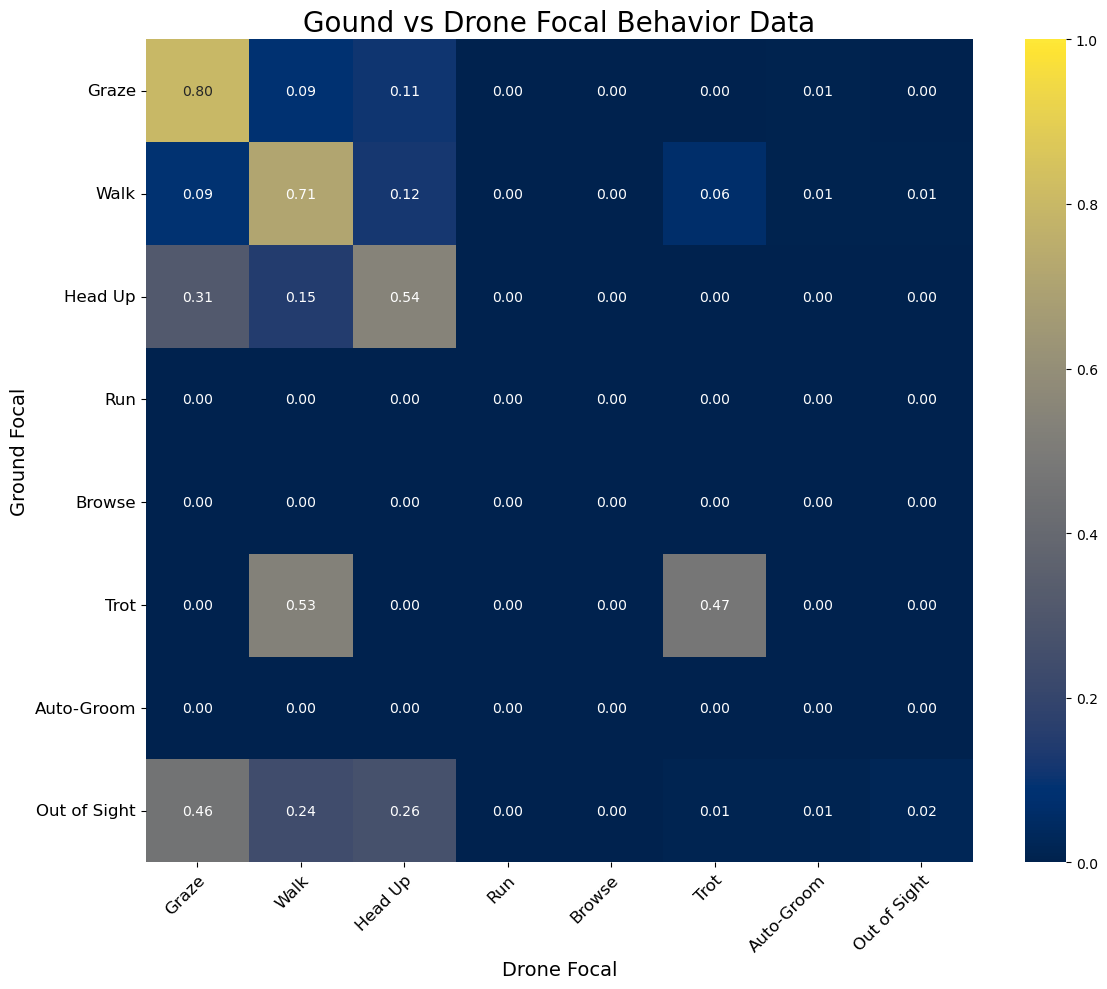

In [42]:
import seaborn as sns
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(12, 10))
sns.heatmap(cm,
            annot=True, fmt=".2f",
            xticklabels=labels,
            yticklabels=labels,
            cmap='cividis', vmin=0, vmax=1)
ax.set_xlabel("Drone Focal", fontsize=14)
ax.set_ylabel("Ground Focal", fontsize=14)
ax.set_title("Gound vs Drone Focal Behavior Data", fontsize=20)
plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor", fontsize=12)
plt.setp(ax.get_yticklabels(), rotation=0, ha="right", fontsize=12)
plt.tight_layout()
plt.show()

fig.savefig("../cm-focal-vs-drone.pdf", dpi=300)

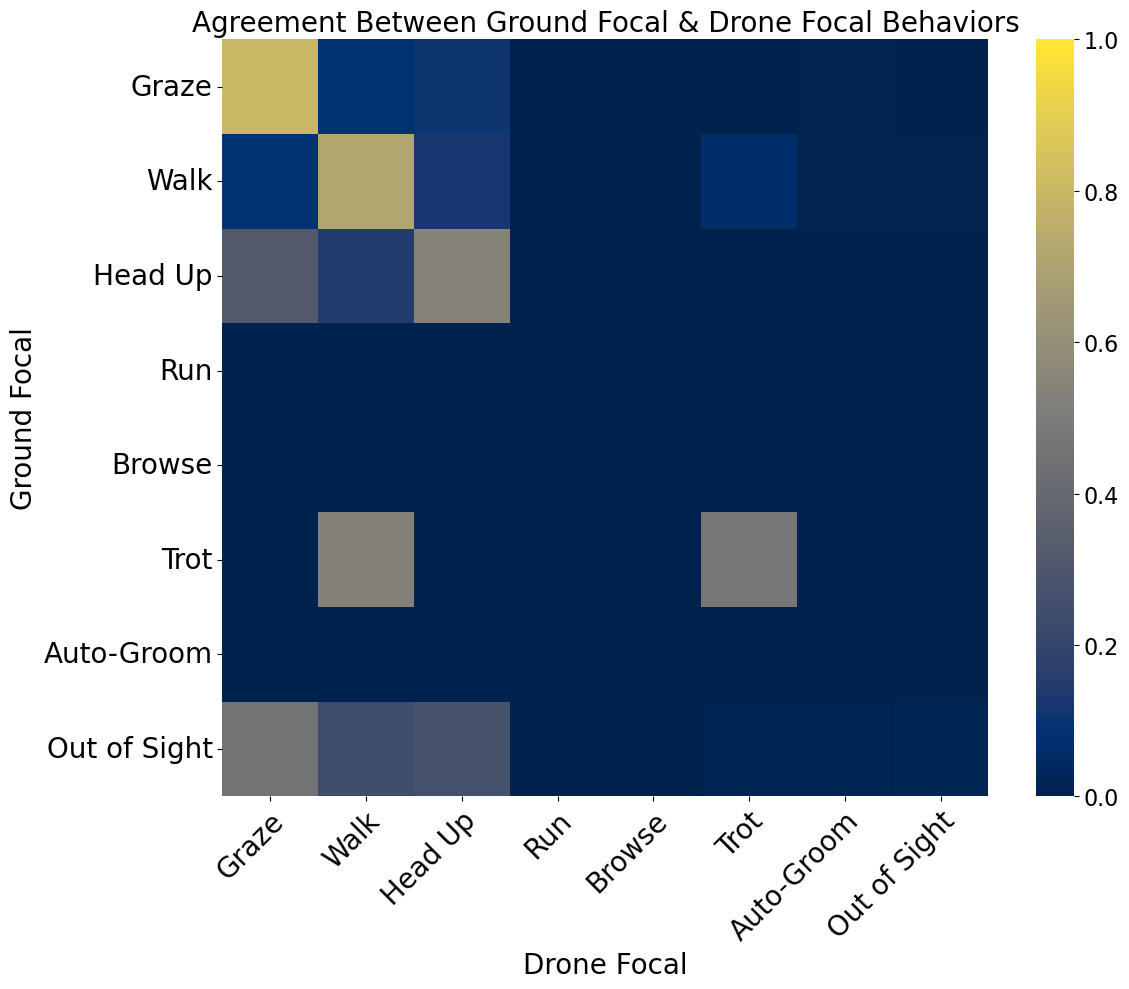

In [12]:
fig, ax = plt.subplots(figsize=(12, 10))
heatmap = sns.heatmap(cm,
                      annot=False, fmt=".2f",
                      xticklabels=labels,
                      yticklabels=labels,
                      cmap='cividis', vmin=0, vmax=1)  # Add label only here

# Set font size for the color bar
cbar = heatmap.collections[0].colorbar
cbar.ax.tick_params(labelsize=16)  # Adjust tick label font size
#cbar.set_label("Color Bar Label", fontsize=20)  # Adjust color bar label font size

# Set other axis labels and title
ax.set_xlabel("Drone Focal", fontsize=20)
ax.set_ylabel("Ground Focal", fontsize=20)
ax.set_title("Agreement Between Ground Focal & Drone Focal Behaviors", fontsize=20)

# Customize tick labels
plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor", fontsize=20)
plt.setp(ax.get_yticklabels(), rotation=0, ha="right", fontsize=20)

plt.tight_layout()
plt.show()

fig.savefig("../cm-focal-vs-drone.pdf", dpi=300)

In [20]:
# get count of 'Out of Sight' in field and drone
df = read_csvs('focalvsdrone')
 
def count_oos(df):
    field = [clean_categories(label) for label in df.get_column("field").to_list()]
    drone = [clean_categories(label) for label in df.get_column("drone").to_list()]
    field_oos = field.count("Out of Sight")
    drone_oos = drone.count("Out of Sight")
    return field_oos, drone_oos
field_oos, drone_oos = count_oos(df)

# print the count of 'Out of Sight' in field and drone
print(f"Field Out of Sight: {field_oos}, Drone Out of Sight: {drone_oos}")

print(f"Field Out of Sight (sec): {field_oos/30}, Drone Out of Sight (sec): {drone_oos/30}")

Field Out of Sight: 23804, Drone Out of Sight: 532
Field Out of Sight (sec): 793.4666666666667, Drone Out of Sight (sec): 17.733333333333334


In [38]:
793.4666666666667/1323.457999

0.5995404971417356

In [39]:
17.733333333333334/1323.457999

0.013399241492161124

In [23]:
# get total length of each session
def get_total_length(df):
    return df.height

total_length = get_total_length(df)
print(f"Total length (frames): {total_length}, Total length (sec): {total_length/30}, Total length (min): {total_length/30/60}")

Total length (frames): 38166, Total length (sec): 1272.2, Total length (min): 21.203333333333333


In [25]:
# get max and min timestamp of each session
def get_max_min_timestamp(df):
    max_timestamp = df.get_column("time").max()
    min_timestamp = df.get_column("time").min()
    return max_timestamp, min_timestamp

max_timestamp, min_timestamp = get_max_min_timestamp(df)
print(f"Max timestamp: {max_timestamp}, Min timestamp: {min_timestamp}")

Max timestamp: 1900-01-01 15:07:44.473000, Min timestamp: 1900-01-01 10:40:56.090000


In [36]:
# list of dfs
def list_dfs(root):
    return [pl.read_csv(os.path.join(root, file)) for file in os.listdir(root)]
def get_session_lengths(dfs):
    lengths = []
    for df in dfs:
        length = df.height
        lengths.append(length)
    return lengths

def get_max_min_timestamps(dfs):
    max_timestamps = []
    min_timestamps = []
    for df in dfs:
        max_timestamp, min_timestamp = get_max_min_timestamp(df)
        max_timestamps.append(max_timestamp)
        min_timestamps.append(min_timestamp)
    return max_timestamps, min_timestamps

dfs = list_dfs('/fs/ess/PAS2136/Kenya-2023/Zebras/methods_paper_analysis/kabr-tools/_hugging_face/methodology_comparison/focalvsdrone/data')
session_lengths = get_session_lengths(dfs)
print(f"Session lengths (frames): {session_lengths}")
print(f"Session lengths (sec): {[length/30 for length in session_lengths]}")
max_timestamps, min_timestamps = get_max_min_timestamps(dfs)

# print the max and min timestamps of each session
print(f"Max timestamps: {max_timestamps}")
print(f"Min timestamps: {min_timestamps}")

from datetime import datetime

def get_timestamp_differences(max_timestamps, min_timestamps):
    # Convert strings to datetime objects
    max_timestamps = [datetime.fromisoformat(ts) for ts in max_timestamps]
    min_timestamps = [datetime.fromisoformat(ts) for ts in min_timestamps]
    # Calculate differences in seconds
    return [(max_ts - min_ts).total_seconds() for max_ts, min_ts in zip(max_timestamps, min_timestamps)]

timestamp_differences = get_timestamp_differences(max_timestamps, min_timestamps)
print(f"Timestamp differences (sec): {timestamp_differences}")
print(f"Timestamp differences (min): {[diff/60 for diff in timestamp_differences]}")


Session lengths (frames): [9413, 5819, 12409, 10525]
Session lengths (sec): [313.76666666666665, 193.96666666666667, 413.6333333333333, 350.8333333333333]
Max timestamps: ['1900-01-01 12:21:56.938667', '1900-01-01 10:44:10.023333', '1900-01-01 15:05:34.364333', '1900-01-01 15:07:44.473000']
Min timestamps: ['1900-01-01 12:15:44.297000', '1900-01-01 10:40:56.090000', '1900-01-01 14:58:48.556667', '1900-01-01 15:01:53.397667']
Timestamp differences (sec): [372.641667, 193.933333, 405.807666, 351.075333]
Timestamp differences (min): [6.21069445, 3.2322222166666665, 6.7634611, 5.85125555]


In [34]:
# sum timestamp differences
total_timestamp_difference = sum(timestamp_differences)
print(f"Total timestamp difference (sec): {total_timestamp_difference}")
# convert total timestamp difference to minutes
total_timestamp_difference_minutes = total_timestamp_difference / 60
print(f"Total timestamp difference (min): {total_timestamp_difference_minutes}")

Total timestamp difference (sec): 1323.457999
Total timestamp difference (min): 22.057633316666667


In [35]:
# average session time
average_session_time = total_timestamp_difference / len(dfs)
print(f"Average session time (sec): {average_session_time}")

# average session std deviation
average_session_std = np.std(timestamp_differences)
print(f"Average session std deviation (sec): {average_session_std}")

Average session time (sec): 330.86449975
Average session std deviation (sec): 81.42547525066283
